In [34]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, CenteredNorm
import numpy as np
from pprint import pprint
from pyHalo.preset_models import preset_model_from_name

import mejiro
plt.style.use(os.path.join(mejiro.__path__[0], 'mejiro.mplstyle'))
from mejiro.analysis import stats
from mejiro.exposure import Exposure
from mejiro.instruments.roman import Roman
from mejiro.galaxy_galaxy import Sample1, Sample2, SampleGG
from mejiro.synthetic_image import SyntheticImage
from mejiro.utils import lenstronomy_util
from mejiro.engines.galsim_engine import GalSimEngine
from mejiro.engines.stpsf_engine import STPSFEngine

In [2]:
strong_lens = Sample1()

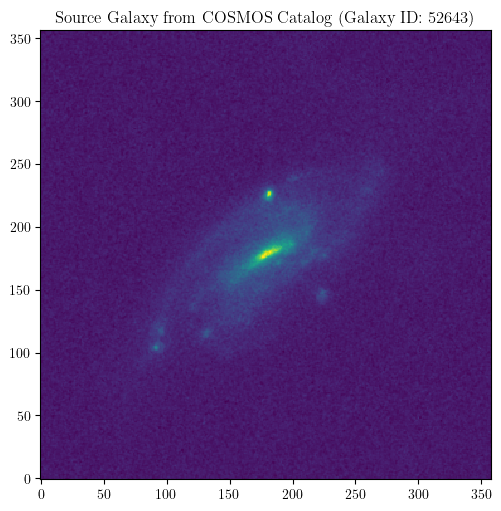

In [3]:
plt.imshow(strong_lens.kwargs_source[0]['image'])
plt.title(f'Source Galaxy from COSMOS Catalog (Galaxy ID: {strong_lens.physical_params["galaxy_id"]})')
plt.show()

In [4]:
kwargs_numerics = SyntheticImage.DEFAULT_KWARGS_NUMERICS
pprint(kwargs_numerics)

{'compute_indexes': None,
 'compute_mode': 'regular',
 'flux_evaluate_indexes': None,
 'point_source_supersampling_factor': 5,
 'supersampled_indexes': None,
 'supersampling_convolution': True,
 'supersampling_factor': 5,
 'supersampling_kernel_size': None}


Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.


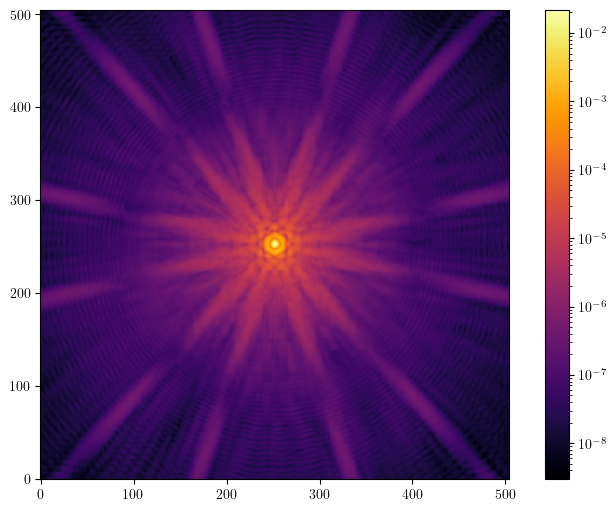

In [5]:
roman = Roman()
band = 'F129'

instrument_params = roman.default_params()
kernel = STPSFEngine.get_roman_psf(band=band,
                                   detector=instrument_params['detector'],
                                   detector_position=instrument_params['detector_position'],
                                   oversample=kwargs_numerics['supersampling_factor'],
                                   num_pix=101,
                                   verbose=True)
kwargs_psf = lenstronomy_util.get_pixel_psf_kwargs(kernel=kernel,
                                                   supersampling_factor=kwargs_numerics['supersampling_factor'])

plt.imshow(kernel, cmap='inferno', norm=LogNorm())
plt.colorbar()
plt.show()

Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 1.957 s


/nfshome/bwedig/mejiro/mejiro/synthetic_image.py:295: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(self.image), origin='lower')


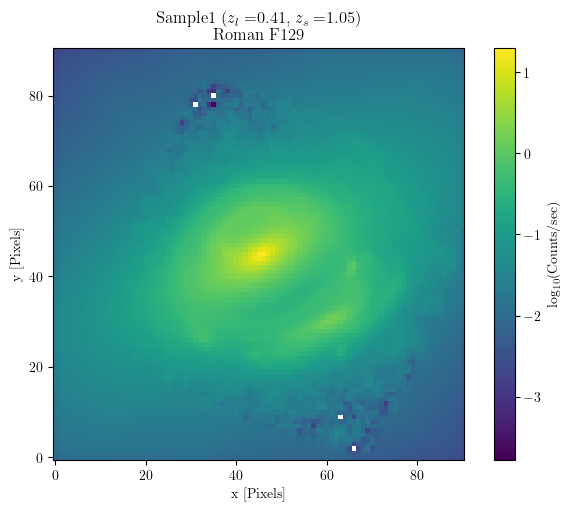

In [6]:
synthetic_image = SyntheticImage(strong_lens,
                                 instrument=roman,
                                 band=band,
                                 fov_arcsec=10,
                                 instrument_params=instrument_params,
                                #  kwargs_numerics=kwargs_numerics,
                                 kwargs_psf=kwargs_psf,
                                 pieces=True,
                                 verbose=True)

synthetic_image.plot()

In [30]:
supersampling_factors = [1, 3, 5, 7, 9, 11, 21]
kernels = []
images = []
calc_times = []

for supersampling_factor in supersampling_factors:
    kwargs_numerics = {
        'compute_mode': 'regular',
        'supersampling_factor': supersampling_factor,
    }
    
    kernel = STPSFEngine.get_roman_psf(band=band,
                                    detector=instrument_params['detector'],
                                    detector_position=instrument_params['detector_position'],
                                    oversample=kwargs_numerics['supersampling_factor'],
                                    num_pix=101,
                                    verbose=True)
    kernels.append(kernel)

    kwargs_psf = lenstronomy_util.get_pixel_psf_kwargs(kernel=kernel,
                                                    supersampling_factor=kwargs_numerics['supersampling_factor'])
    
    synthetic_image = SyntheticImage(strong_lens,
                                 instrument=roman,
                                 band=band,
                                 fov_arcsec=10,
                                 instrument_params=instrument_params,
                                 kwargs_numerics=kwargs_numerics,
                                 kwargs_psf=kwargs_psf,
                                 pieces=True,
                                 verbose=True)
    images.append(synthetic_image.image)
    calc_times.append(synthetic_image.calc_time)

Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.037 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.


/nfshome/bwedig/mejiro/mejiro/synthetic_image.py:160: UserWarning: Supersampling factor less than 5 may not be sufficient for accurate results, especially when convolving with a non-trivial PSF
  warnings.warn('Supersampling factor less than 5 may not be sufficient for accurate results, especially when convolving with a non-trivial PSF')


Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.121 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.


/nfshome/bwedig/mejiro/mejiro/synthetic_image.py:160: UserWarning: Supersampling factor less than 5 may not be sufficient for accurate results, especially when convolving with a non-trivial PSF
  warnings.warn('Supersampling factor less than 5 may not be sufficient for accurate results, especially when convolving with a non-trivial PSF')


Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.23 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.433 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.667 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.999 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 3.617 s


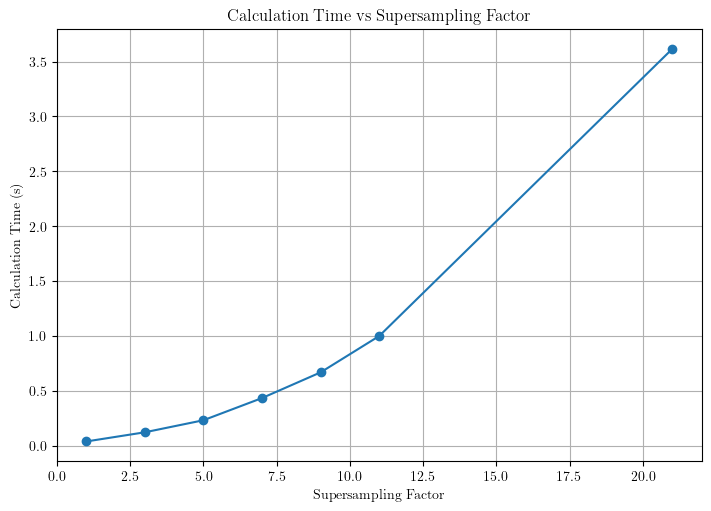

In [31]:
plt.figure()
plt.plot(supersampling_factors, calc_times, marker='o')
plt.xlabel('Supersampling Factor')
plt.ylabel('Calculation Time (s)')
plt.title('Calculation Time vs Supersampling Factor')
plt.grid(True)
plt.show()

/tmp/ipykernel_1444823/4004979994.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


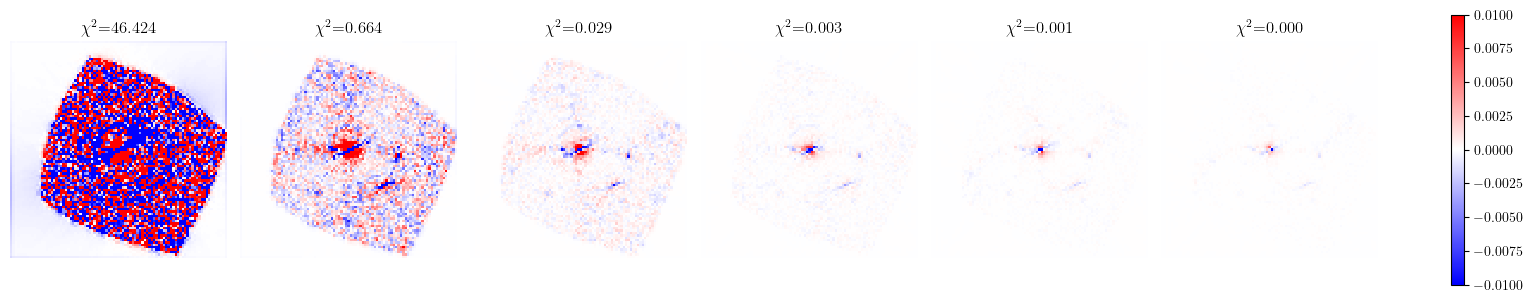

In [33]:
vmax = max(np.max(np.abs(images[-1] - img)) for img in images)
vmin = -vmax

vmin=-0.01
vmax=0.01

f, ax = plt.subplots(1, len(images) - 1, figsize=(15, 3))
for i, img in enumerate(images[:-1]):
    diff = images[-1] - img
    chi2 = stats.chi_square(img, images[-1])
    im = ax[i].imshow(diff, cmap='bwr', vmin=vmin, vmax=vmax)
    ax[i].set_title(r'$\chi^2$' + f'={chi2:.3f}')
    ax[i].axis('off')
plt.tight_layout()
f.colorbar(im, ax=ax, orientation='vertical', fraction=0.02)
plt.show()

In [37]:
supersampling_factors = [1, 3, 5, 7, 9, 11, 21]
kernels = []
images = []
calc_times = []

strong_lens = SampleGG()

for supersampling_factor in supersampling_factors:
    kwargs_numerics = {
        'compute_mode': 'regular',
        'supersampling_factor': supersampling_factor,
    }
    
    kernel = STPSFEngine.get_roman_psf(band=band,
                                    detector=instrument_params['detector'],
                                    detector_position=instrument_params['detector_position'],
                                    oversample=kwargs_numerics['supersampling_factor'],
                                    num_pix=101,
                                    verbose=True)
    kernels.append(kernel)

    kwargs_psf = lenstronomy_util.get_pixel_psf_kwargs(kernel=kernel,
                                                    supersampling_factor=kwargs_numerics['supersampling_factor'])
    
    synthetic_image = SyntheticImage(strong_lens,
                                 instrument=roman,
                                 band=band,
                                 fov_arcsec=10,
                                 instrument_params=instrument_params,
                                 kwargs_numerics=kwargs_numerics,
                                 kwargs_psf=kwargs_psf,
                                 pieces=True,
                                 verbose=True)
    images.append(synthetic_image.image)
    calc_times.append(synthetic_image.calc_time)

Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.011 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.


/nfshome/bwedig/mejiro/mejiro/synthetic_image.py:160: UserWarning: Supersampling factor less than 5 may not be sufficient for accurate results, especially when convolving with a non-trivial PSF
  warnings.warn('Supersampling factor less than 5 may not be sufficient for accurate results, especially when convolving with a non-trivial PSF')


Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.03 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.


/nfshome/bwedig/mejiro/mejiro/synthetic_image.py:160: UserWarning: Supersampling factor less than 5 may not be sufficient for accurate results, especially when convolving with a non-trivial PSF
  warnings.warn('Supersampling factor less than 5 may not be sufficient for accurate results, especially when convolving with a non-trivial PSF')


Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.067 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.112 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.174 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.245 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.971 s


/tmp/ipykernel_1444823/4004979994.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


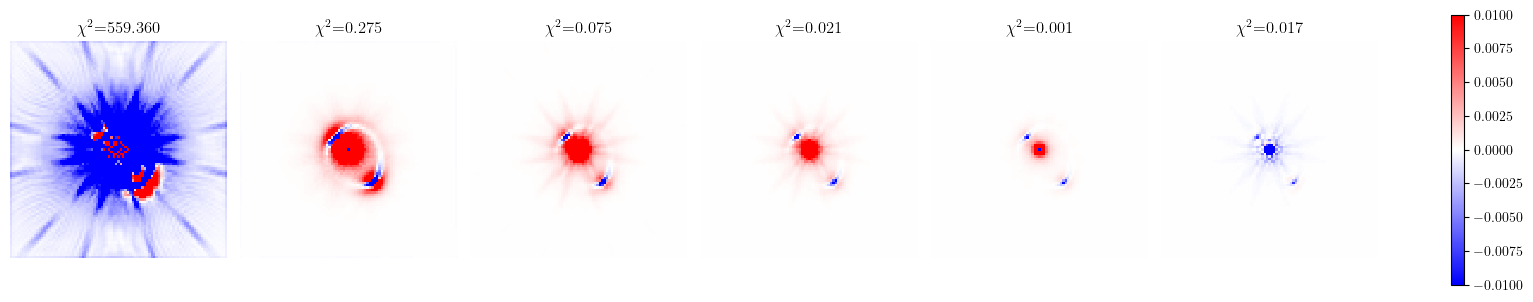

: 

In [ ]:
vmax = max(np.max(np.abs(images[-1] - img)) for img in images)
vmin = -vmax

vmin=-0.01
vmax=0.01

f, ax = plt.subplots(1, len(images) - 1, figsize=(15, 3))
for i, img in enumerate(images[:-1]):
    diff = images[-1] - img
    chi2 = stats.chi_square(img, images[-1])
    im = ax[i].imshow(diff, cmap='bwr', vmin=vmin, vmax=vmax)
    ax[i].set_title(r'$\chi^2$' + f'={chi2:.3f}')
    ax[i].axis('off')
plt.tight_layout()
f.colorbar(im, ax=ax, orientation='vertical', fraction=0.02)
plt.show()